In [0]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
import time
import numpy as np

In [0]:
mnist = torchvision.datasets.MNIST('data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
dataloader = DataLoader(mnist, batch_size=128, shuffle=True)

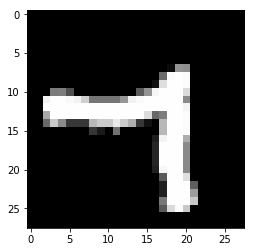

In [37]:
images, labels = next(iter(dataloader))

plt.imshow(images[0, 0], cmap='Greys_r')
plt.show()

In [0]:
class MaskedConv2d(nn.Conv2d):
	def __init__(self, mask_center, *args, **kwargs):
		super(MaskedConv2d, self).__init__(*args, **kwargs)
		self.register_buffer('mask', self.weight.data.clone())
		_, _, kH, kW = self.weight.size()
		self.mask.fill_(1)
		self.mask[:, :, kH // 2, kW // 2 + (mask_center == False):] = 0
		self.mask[:, :, kH // 2 + 1:] = 0

	def forward(self, x):
		self.weight.data *= self.mask
		return super(MaskedConv2d, self).forward(x)

class Upsample2D(nn.Module):
    def __init__(self, scale_factor, mode='nearest'):
        super(Upsample2D, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x
    
class ResidualMaskedConv2d(nn.Module):
	def __init__(self, hidden_size, kernel_size=3):
		super(ResidualMaskedConv2d, self).__init__()
		
		self.residual = nn.Sequential(
            MaskedConv2d(False, hidden_size, hidden_size//2, kernel_size=1, bias=False), 
			nn.BatchNorm2d(hidden_size//2),
			nn.ReLU(inplace=True),
			MaskedConv2d(False, hidden_size//2, hidden_size//2, kernel_size=kernel_size, padding=kernel_size//2, bias=False), 
			nn.BatchNorm2d(hidden_size//2), 
			nn.ReLU(inplace=True),
			MaskedConv2d(False, hidden_size//2, hidden_size, kernel_size=1, bias=False), 
			nn.BatchNorm2d(hidden_size),
		)	

	def forward(self, x):
		return x + self.residual(x)

class PixelCNN(nn.Module):
    def __init__(self, num_classes, hidden_size=64):
        super(PixelCNN, self).__init__()
        
        self.initial = nn.Sequential(
            MaskedConv2d(True, 1, hidden_size, kernel_size=7, padding=3, bias=False), 
            nn.BatchNorm2d(hidden_size), 
            nn.ReLU(inplace=True)  
        )
        
        self.class_embedding = nn.Embedding(num_classes, hidden_size)
        
        self.cnn = nn.Sequential(          
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),          
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),          
            ResidualMaskedConv2d(hidden_size),
            ResidualMaskedConv2d(hidden_size),
            ResidualMaskedConv2d(hidden_size),
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            MaskedConv2d(False, hidden_size, hidden_size, kernel_size=7, padding=3, bias=False), nn.BatchNorm2d(hidden_size), nn.ReLU(inplace=True),
            
            nn.Conv2d(hidden_size, 256, kernel_size=1),
        )
        
    def forward(self, x, y=None):
        x = self.initial(x)
        if y is not None:
            y = self.class_embedding(y).unsqueeze(-1).unsqueeze(-1).expand(x.shape)
            x = x + y
        x = self.cnn(x)
        return x

In [52]:
pixelCNN = PixelCNN(num_classes=10, hidden_size=32)
pixelCNN.cuda()

PixelCNN(
  (initial): Sequential(
    (0): MaskedConv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (class_embedding): Embedding(10, 32)
  (cnn): Sequential(
    (0): MaskedConv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaskedConv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaskedConv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ResidualMaskedConv2d(
      (residual): Sequential(
        (0): MaskedCo

In [0]:
# sample
def sample(num_samples = 5, temperature = 1, label=None):   
    sample = torch.zeros(num_samples, 1, 28, 28).cuda()
    if label is None:
        labels = torch.randint(0, 10, (num_samples,)).cuda()
    else:
        labels = torch.tensor([label]*num_samples).cuda()
    print(labels.tolist())
    
    pixelCNN.eval()
    with torch.no_grad():
        for i in range(28):
            for j in range(28):
                pred = pixelCNN(sample, labels)
                pred = (pred[:, :, i, j]/temperature).softmax(dim=-1)                
                sample[:, :, i, j] = torch.multinomial(pred, 1).float() / 255. 

    plt.imshow(torch.cat([s for s in sample], dim=-1)[0].cpu() * 2, cmap='Greys_r')
    plt.show()

Epoch 1 (469/469) - loss 0.73353398049564 (86.3s)
[0, 4, 5, 7, 3]


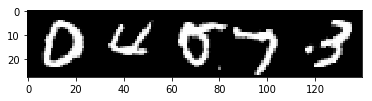

Epoch 2 (469/469) - loss 0.7292657908854454 (85.6s)
[1, 6, 2, 8, 4]


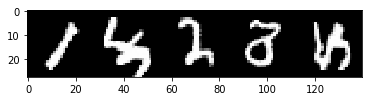

Epoch 3 (469/469) - loss 0.7256703844456784 (87.4s)
[8, 4, 4, 4, 6]


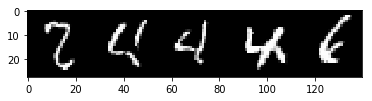

Epoch 4 (469/469) - loss 0.7216813486776372 (87.0s)
[6, 1, 7, 3, 1]


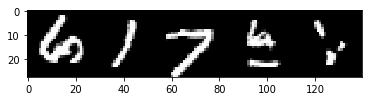

Epoch 5 (469/469) - loss 0.7176754053975982 (86.2s)
[4, 2, 6, 1, 9]


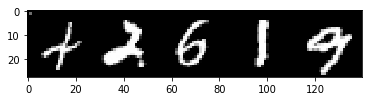

Epoch 6 (469/469) - loss 0.7131405641783529 (85.6s)
[5, 6, 2, 7, 0]


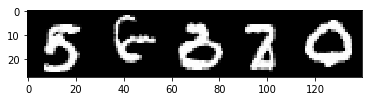

Epoch 7 (469/469) - loss 0.7088394405236885 (87.6s)
[6, 9, 1, 4, 4]


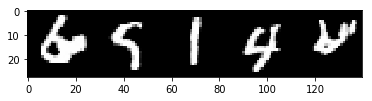

Epoch 8 (469/469) - loss 0.7046304737835296 (87.1s)
[7, 4, 9, 7, 2]


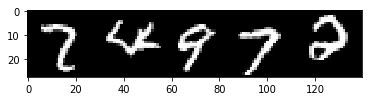

Epoch 9 (469/469) - loss 0.7009813844013825 (86.4s)
[5, 9, 8, 8, 0]


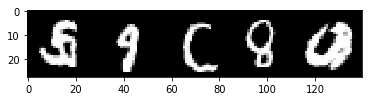

Epoch 10 (469/469) - loss 0.6973755418110504 (85.6s)
[3, 1, 3, 9, 3]


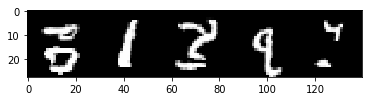

Epoch 11 (469/469) - loss 0.6940178702126688 (87.3s)
[8, 8, 0, 3, 6]


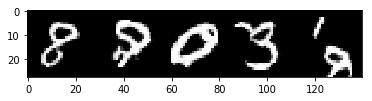

Epoch 12 (469/469) - loss 0.6911420967024781 (86.9s)
[7, 7, 2, 9, 8]


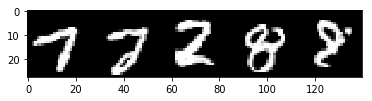

Epoch 13 (469/469) - loss 0.687860563619813 (86.2s)
[6, 5, 8, 2, 3]


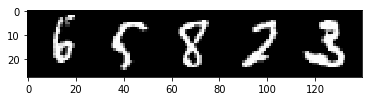

Epoch 14 (469/469) - loss 0.6855906821263116 (85.4s)
[3, 9, 3, 5, 3]


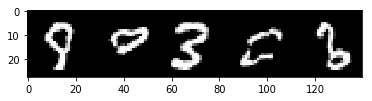

Epoch 15 (469/469) - loss 0.6829533111820343 (87.2s)
[2, 2, 4, 3, 4]


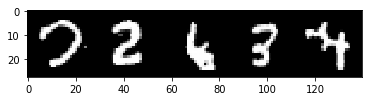

In [70]:
epochs = 15
print_every = 500

optimizer = optim.Adam(pixelCNN.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss() # weight=torch.tensor([1.0]+([2.0]*255)).cuda())

for e in range(1, epochs+1):
    total_loss = 0
    pixelCNN.train()
    start_time = time.time()
    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.cuda(), labels.cuda()
        target = (images[:,0] * 255).long()
        
        pred = pixelCNN(images, labels)       
        loss = criterion(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch+1) % print_every == 0 or (batch+1) == len(dataloader):
            elapsed_time = time.time() - start_time
            start_time = time.time()
            print(f"Epoch {e} ({batch+1}/{len(dataloader)}) - loss {total_loss/(batch+1)} ({elapsed_time:.1f}s)")
    
    sample(num_samples = 5) # sample after every epoch
    # scheduler.step()

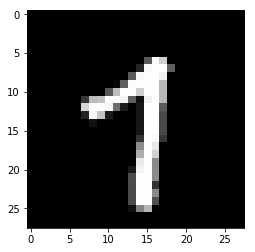

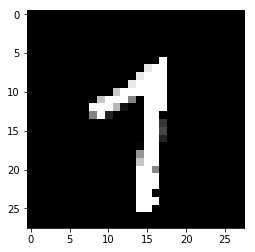

In [73]:
# check generation
images, labels = next(iter(dataloader))
pixelCNN.eval()
with torch.no_grad():
    pred = pixelCNN(images.cuda())
    pred = pred.softmax(-3).argmax(-3)

plt.imshow(images[0,0].cpu(), cmap='Greys_r')
plt.show()
plt.imshow(pred[0].cpu(), cmap='Greys_r')
plt.show()

[9, 9, 9, 9, 9]


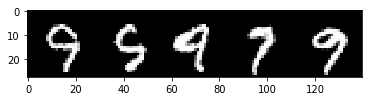

In [91]:
sample(num_samples = 5, temperature=1, label=9)

In [0]:
 class PixelSelfAttention(nn.Module):
    def __init__(self, channels, max_size, mask_center=False, heads = 4):
        super(PixelSelfAttention, self).__init__()       
        self.heads = heads
        self.head_size = channels // heads
        
        self.get_query = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        self.get_key = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        self.get_value = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        
        self.combine = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        
        self.register_buffer('mask', self.gen_mask(max_size, mask_center))       
        
    def gen_mask(self, max_size, mask_center):
        masks = torch.ones(1, max_size**2, max_size, max_size)
        for i in range(0, max_size):
            for j in range(0, max_size):
                masks[:, i*max_size+j, i, j + (mask_center == False):] = 0
                masks[:, i*max_size+j, i + 1:] = 0
        return masks.view(1, max_size**2, max_size**2)
        
    def forward(self, x):  
        query = self.get_query(x).permute(0, 2, 3, 1).view(x.size(0), -1, self.heads, self.head_size).transpose(1,2)
        key = self.get_key(x).permute(0, 2, 3, 1).view(x.size(0), -1, self.heads, self.head_size).transpose(1,2)
        value = self.get_value(x).permute(0, 2, 3, 1).view(x.size(0), -1, self.heads, self.head_size).transpose(1,2) 
                
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))
        scores = scores.masked_fill(self.mask.unsqueeze(0)[:,:,:scores.size(-2), :scores.size(-1)] == 0, -1e9).softmax(dim=-1)
        scores = torch.matmul(scores, value) 
        scores = scores.transpose(1,2).contiguous().view(x.size(0), x.size(2), x.size(3), x.size(1)).permute(0, 3, 1, 2)
        scores = self.combine(scores)
                
        return scores

class PixelPositionalEncoder(nn.Module):
    def __init__(self, embedding_size, max_size):
        super(PixelPositionalEncoder, self).__init__()
        self.embedding_size = embedding_size
        
        pos_encoder = torch.zeros(embedding_size, max_size, max_size)
        
        for k in range(0, embedding_size, 2):
            for i in range(max_size):
                for j in range(max_size):                
                    pos_encoder[k, i, j] = math.sin((j+i*max_size) / (10000 ** ((2 * k)/embedding_size)))
                    if (k + 1) < pos_encoder.size(0):
                        pos_encoder[k + 1, i, j] = math.cos((j+i*max_size) / (10000 ** ((2 * (k + 1))/embedding_size)))
                
        pos_encoder = pos_encoder.unsqueeze(0)
        self.register_buffer('pos_encoder', pos_encoder)
 
    def forward(self, x):
        x = x * math.sqrt(self.embedding_size)
        seq_len = x.size(1)
        x = x + self.pos_encoder[:, :, :x.size(-2), :x.size(-1)]
        return x

In [0]:
class PixelTransformer(nn.Module):
    def __init__(self, hidden_size=64):
        super(PixelTransformer, self).__init__()
        
        max_size = 28
        self.expand = nn.Conv2d(1, hidden_size, kernel_size=1)
        self.pos_encoder = PixelPositionalEncoder(hidden_size, max_size)
        
        self.cnn = nn.Sequential(
            nn.BatchNorm2d(hidden_size),
            PixelSelfAttention(hidden_size, max_size, mask_center=True, heads=4),
            nn.ReLU(),
            
            nn.BatchNorm2d(hidden_size),
            PixelSelfAttention(hidden_size, max_size, mask_center=False, heads=4),
            nn.ReLU(),
            
            nn.BatchNorm2d(hidden_size),
            PixelSelfAttention(hidden_size, max_size, mask_center=False, heads=4),
            nn.ReLU(),
            
            nn.BatchNorm2d(hidden_size),
            PixelSelfAttention(hidden_size, max_size, mask_center=False, heads=4),
            nn.ReLU(),
            
            nn.BatchNorm2d(hidden_size),
            nn.Conv2d(hidden_size, 256, kernel_size=1),
        )
        
    def forward(self, x):
        x = self.expand(x)
        x = self.pos_encoder(x)
        x = self.cnn(x)
        return x

In [9]:
pixelTransformer = PixelTransformer(64)
pixelTransformer.cuda()

PixelTransformer(
  (expand): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
  (pos_encoder): PixelPositionalEncoder()
  (cnn): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): PixelSelfAttention(
      (get_query): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (get_key): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (get_value): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (combine): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): PixelSelfAttention(
      (get_query): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (get_key): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (get_value): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (combine): Conv2d(64, 64, kernel_

In [0]:
# sample
def sample(num_samples = 5, temperature = 1):   
    sample = torch.zeros(num_samples, 1, 28, 28).cuda()
    
    pixelTransformer.eval()
    with torch.no_grad():
        for i in range(28):
            for j in range(28):
                pred = pixelTransformer(sample)
                pred = (pred[:, :, i, j]/temperature).softmax(dim=-1)                
                sample[:, :, i, j] = torch.multinomial(pred, 1).float() / 255. 

    plt.imshow(torch.cat([s for s in sample], dim=-1)[0].cpu() * 2, cmap='Greys_r')
    plt.show()

In [0]:
torch.cuda.empty_cache()

Epoch 1 (500/1875) - loss 1.2763113232851029 (211.9s)
Epoch 1 (1000/1875) - loss 0.8807005088329315 (211.5s)
Epoch 1 (1500/1875) - loss 0.7224029841224352 (211.8s)
Epoch 1 (1875/1875) - loss 0.6510951862017313 (158.5s)


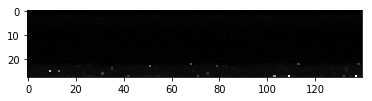

Epoch 2 (500/1875) - loss 0.343526752948761 (211.5s)
Epoch 2 (1000/1875) - loss 0.3321769417822361 (211.7s)
Epoch 2 (1500/1875) - loss 0.32474074931939445 (211.6s)
Epoch 2 (1875/1875) - loss 0.31894466602802274 (158.7s)


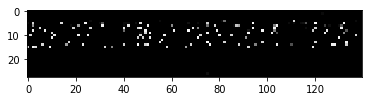

Epoch 3 (500/1875) - loss 0.285111782848835 (211.7s)
Epoch 3 (1000/1875) - loss 0.2779842385351658 (211.4s)
Epoch 3 (1500/1875) - loss 0.2733915004233519 (211.5s)
Epoch 3 (1875/1875) - loss 0.2697439948797226 (158.6s)


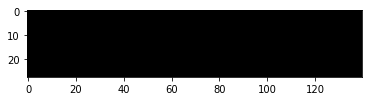

Epoch 4 (500/1875) - loss 0.24872218778729438 (211.4s)
Epoch 4 (1000/1875) - loss 0.24738363699615 (211.4s)
Epoch 4 (1500/1875) - loss 0.24570720712343852 (211.4s)
Epoch 4 (1875/1875) - loss 0.2421254243214925 (158.6s)


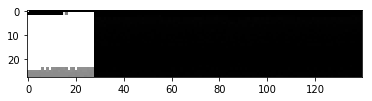

Epoch 5 (500/1875) - loss 0.23126932641863823 (211.6s)
Epoch 5 (1000/1875) - loss 0.22898585399985313 (211.5s)
Epoch 5 (1500/1875) - loss 0.23032855707407 (211.6s)
Epoch 5 (1875/1875) - loss 0.2269358463048935 (158.7s)


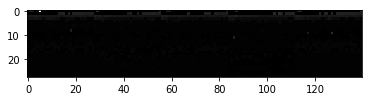

KeyboardInterrupt: ignored

In [12]:
epochs = 20
print_every = 500

optimizer = optim.Adam(pixelTransformer.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion = nn.CrossEntropyLoss() # weight=torch.tensor([1.0]+([2.0]*255)).cuda())

for e in range(1, epochs+1):
    total_loss = 0
    pixelTransformer.train()
    start_time = time.time()
    for batch, (images, labels) in enumerate(dataloader):
        images = images.cuda()
        target = (images[:,0] * 255).long()
        
        pred = pixelTransformer(images)       
        loss = criterion(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if (batch+1) % print_every == 0 or (batch+1) == len(dataloader):
            elapsed_time = time.time() - start_time
            start_time = time.time()
            print(f"Epoch {e} ({batch+1}/{len(dataloader)}) - loss {total_loss/(batch+1)} ({elapsed_time:.1f}s)")
    
    sample(num_samples = 5) # sample after every epoch
    # scheduler.step()

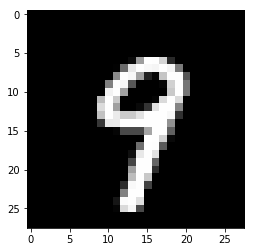

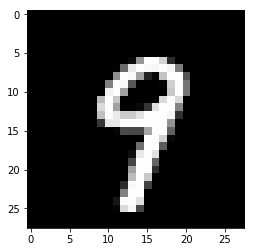

In [13]:
# check generation
images, labels = next(iter(dataloader))
pixelCNN.eval()
with torch.no_grad():
    pred = pixelTransformer(images.cuda())
    pred = pred.softmax(-3).argmax(-3)

plt.imshow(images[0,0].cpu(), cmap='Greys_r')
plt.show()
plt.imshow(pred[0].cpu(), cmap='Greys_r')
plt.show()

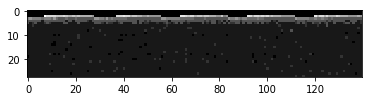

In [14]:
sample(num_samples = 5)